## Reaction-diffusion model

The aim of this notebook is to provide insight with devito into so-called reaction-diffusion models. These are problems which, intuitively, involve some reaction that occurs, and results in some form of diffusion.

This may sound initially vague, but has a variety of application that illustrate its meaning. The first of these is cell multiplication -- the cell population will diffuse outwards, following the reaction of duplication which individual cells undergo.

This problem is an answer to Lorena Barba's reaction-diffusion notebook which can be found <a href="https://github.com/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_06_Reaction_Diffusion.ipynb">here</a>. Like our CFD examples, we start by setting up the problem, and will then create a quick and easy Devito solution to it.

We start by introducing the problem.

#### The problem ####

<ul>
    <li> Discretize the reaction-diffusion equations using forward-time/central-space and assume that $$ \Delta x = \Delta y = \delta $$
    <li> For our timestep, set $$ \Delta t = \frac{9}{40} \frac{\delta ^ 2}{max(D_u, D_v)} $$
    <li> Use zero Neumann boundary conditions on all sides of the domain.
</ul>

The initial conditions and constants we are given are listed in the cell below, and correspond to the domain:

<ul>
    <li> A grid with dimensions 192 $ \times $ 192 points
    <li> Domain is the 5 m $ \times $ 5 m
    <li> Final time is 8000 s
</ul>

#### The Gray-Scott Model

Lorena Barba introduces the Gray-Scott model in her tutorial. The important equations we get from it are:

$$ \frac{\partial u}{\partial t} = D_u \nabla ^2 u - uv^2 + F(1 - u) $$
$$ \frac{\partial v}{\partial t} = D_v \nabla ^2 v + uv^2 - (F + k)v $$\

where
<ul> 
    <li>Species $U$ is added at a constant feed rate into the system.
    <li>Two units of species V can 'turn' a unit of species U into V: $\; 2V+U\rightarrow 3V$
    <li>There's a constant kill rate removing species $V$.
</ul>

In [1]:
import numpy
from matplotlib import pyplot
import matplotlib.cm as cm
%matplotlib inline

In [2]:
n = 192

Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065 # Bacteria 1 

dh = 5/(n-1)

T = 8000

dt = .9 * dh**2 / (4*max(Du,Dv))

nt = int(T/dt)

#### Initial Conditions ####

Also given to us in the problem is the initial conditions which contains two numpy arrays which hold the initial values for `U` and `V`, respectively.

In [3]:
from devito import Operator, TimeData, x, y, t
from sympy import Eq, solve
from sympy.abc import h, s

uvinitial = numpy.load('./data/uvinitial.npz')
V = TimeData(name='V', shape=uvinitial['V'].shape, space_order=2)
U = TimeData(name='U', shape=uvinitial['V'].shape, space_order=2) 
U.data[0,:,:] = uvinitial['U']
V.data[0,:,:] = uvinitial['V']

#### Devito Implementation ####

Now let's begin to implement all of this in Devito.

The first thing to do now that we have our timespace and our problem set up is to implement the Gray-Scott model as outlined in Lorena Barba's walkthrough.

In [4]:
# Set up initial variables
dx = 5. / (n - 1)
dy = dx

# Initialize the equations and stencil calculations
U_eq = Eq(Du * U.laplace - U * V * V + F * (1. - U) - U.dt, 0.)
V_eq = Eq(Dv * V.laplace + U * V * V - (F + k) * V - V.dt, 0.)

stencil_U = solve(U_eq, U.forward)[0]
stencil_V = solve(V_eq, V.forward)[0]

update_U = Eq(U.forward, stencil_U)
update_V = Eq(V.forward, stencil_V)

# Initialize Neumann boundary conditions for U and V
bc_U = [Eq(U.indexed[t+1, n-1, y], U.indexed[t+1, n-2, y])]  # right
bc_U += [Eq(U.indexed[t+1, x, n-1], U.indexed[t+1, x, n-2])] # top
bc_U += [Eq(U.indexed[t+1, 0, y], U.indexed[t+1, 1, y])]       # left
bc_U += [Eq(U.indexed[t+1, x, 0], U.indexed[t+1, x, 1])]       # bottom

bc_V = [Eq(V.indexed[t+1, n-1, y], V.indexed[t+1, n-2, y])]  # right
bc_V += [Eq(V.indexed[t+1, x, n-1], V.indexed[t+1, x, n-2])] # top
bc_V += [Eq(V.indexed[t+1, 0, y], V.indexed[t+1, 1, y])]     # left
bc_V += [Eq(V.indexed[t+1, x, 0], V.indexed[t+1, x, 1])]     # bottom

In [5]:
# Create the Operator
op = Operator([update_U] + [update_V] + bc_U + bc_V, subs={h:dx, s:dt},
             dse=None, dle=None)

# Execute for a number of timesteps using nt from earlier
op(time=nt+1, U=U, V=V)

CustomCompiler: compiled /var/folders/b0/z7vc8ltj0131yqczz72tf_wm0000gp/T/devito-502/a1089d9dfa2440bfe4ff8082bd8f617f951965ac.c [0.81 s]
Section loop_y_1<8302,191> with OI=0.00 computed in 0.001 s [Perf: 0.00 GFlops/s]
Section loop_x_2<8302,191> with OI=0.00 computed in 0.010 s [Perf: 0.00 GFlops/s]
Section main<8302,191,191> with OI=1.73 computed in 0.548 s [Perf: 15.47 GFlops/s]


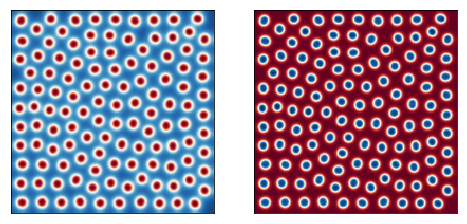

In [6]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(U.data[0], cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(V.data[0], cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

#### References ####
<ul> 
    <li> Reaction-diffusion model, by Lorena Barba https://github.com/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_06_Reaction_Diffusion.ipynb
    <li> Pattern Parameters from http://www.aliensaint.com/uo/java/rd/
    <li> Pearson, J. E. (1993). Complex patterns in a simple system, Science, Vol. 261(5118), 189-192 // PDF from nd.edu.
    <li> Reaction-diffusion tutorial, by Karl Sims http://www.karlsims.com/rd.html
</ul>